# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

zsh:1: no matches found: tensorflow[and-cuda]


In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 0
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [1]:
# System and utilities
import os
import random
import math
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import numpy as np                             # For numerical operations
import pandas as pd                            # For dataframes and data analysis
import seaborn as sns                          # For visualizations
import matplotlib.pyplot as plt                # For plotting
import matplotlib.image as mpimg               # For image visualization

# OpenCV (installed with headless version for compatibility)
!pip install opencv-python-headless -q
import cv2                                     # For image processing

# TensorFlow and Keras modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16

# Scikit-learn utilities
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    classification_report,
    mean_squared_error as mse
)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [5]:
# load image and label data
images = np.load('/Users/shreyamenon/Projects/images_proj.npy')
labels = pd.read_csv('/Users/shreyamenon/Projects/Labels_proj.csv')

# check the shape of both arrays
print(images.shape)  # number of images, height, width, channels
print(labels.shape)  # number of labels and columns

(631, 200, 200, 3)
(631, 1)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

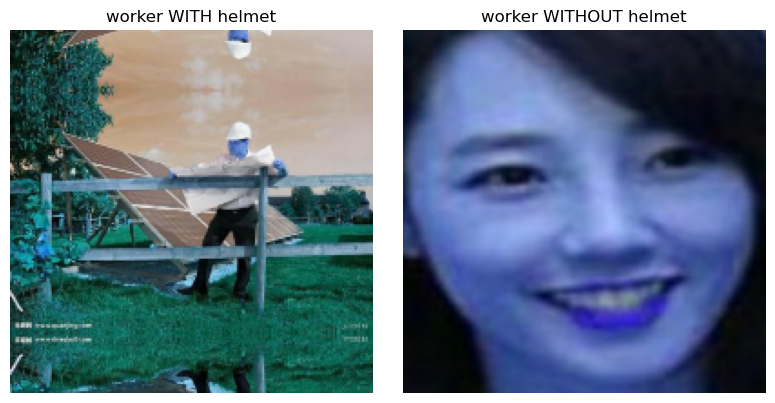

In [8]:
# get indices where label = 1 (with helmet) and 0 (no helmet)
helmet_idx = np.where(labels.values == 1)[0]
no_helmet_idx = np.where(labels.values == 0)[0]

# randomly pick one image from each class
helmet_img = images[np.random.choice(helmet_idx)]
no_helmet_img = images[np.random.choice(no_helmet_idx)]

# plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# show image with helmet
axes[0].imshow(helmet_img)
axes[0].set_title("worker WITH helmet")
axes[0].axis('off')

# show image without helmet
axes[1].imshow(no_helmet_img)
axes[1].set_title("worker WITHOUT helmet")
axes[1].axis('off')

# tidy layout and display both images
plt.tight_layout()
plt.show()

The output shows two sample images—one with a helmet and one without. The colors look off, especially the blue tint on the second image, likely due to not converting from BGR to RGB before plotting. This needs fixing to properly visualize and train the model. The samples also seem visually diverse, which could impact model generalization.

## Checking for class imbalance


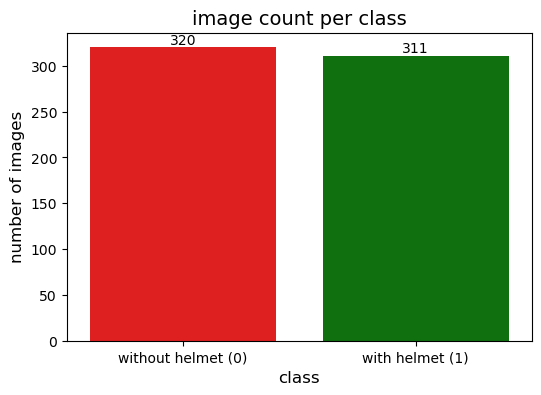

In [10]:
# make a bar chart showing number of images per class
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# add value labels on each bar
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom', fontsize=10)

# add axis titles and chart title
plt.xlabel("class", fontsize=12)
plt.ylabel("number of images", fontsize=12)
plt.title("image count per class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["without helmet (0)", "with helmet (1)"])

# show the chart
plt.show()

The class distribution looks pretty balanced — 320 images without helmets and 311 with helmets. I don’t think I need to worry about class imbalance affecting my model’s performance.

# **Data Preprocessing**

## Converting images to grayscale

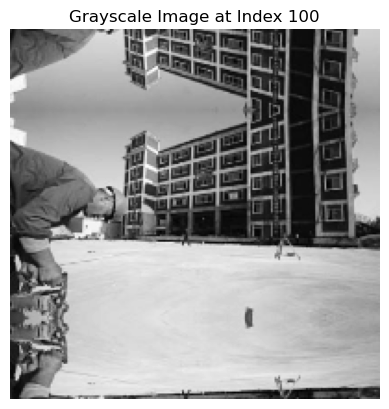

In [13]:
import matplotlib.pyplot as plt
import cv2

# convert all color images to grayscale
images_gray = []

for i in range(len(images)):
    gray_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(gray_img)

# show a grayscale image to confirm
n = 100  # or pick any valid index like 0, 50, etc.
plt.imshow(images_gray[n], cmap='gray')
plt.title(f"Grayscale Image at Index {n}")
plt.axis('off')
plt.show()

Converting the images to grayscale worked successfully. The grayscale version of image index 100 looks clear and retains the structure and features needed for classification. I think this step will help reduce model complexity since color isn't essential for detecting helmets.

### Splitting the dataset



In [15]:
from sklearn.model_selection import train_test_split

# split data into train and temp (temp will be split again)
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images), labels, test_size=0.3, random_state=42, stratify=labels)

# split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# print the shape of all datasets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(441, 200, 200, 3) (441, 1)
(95, 200, 200, 3) (95, 1)
(95, 200, 200, 3) (95, 1)


### Data Normalization

In [17]:
# normalize pixel values by dividing by 255 to scale them between 0 and 1
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

The dataset was split cleanly: 441 images for training and 95 each for validation and testing. Using stratification helps maintain class balance. I normalized the images to scale pixel values between 0 and 1, which should help the model train more efficiently.


# **Model Building**

### Model Evaluation Criterion

## Utility Functions

In [21]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [22]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

## Model 1: Simple Convolutional Neural Network (CNN)

In [24]:
# make the cnn model
model_1 = Sequential()

# add conv and pooling layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)))
model_1.add(MaxPooling2D((4, 4), padding='same'))

model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D((2, 2), padding='same'))

model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# flatten and dense layers
model_1.add(Flatten())
model_1.add(Dense(4, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))  # binary classification

# compile the model
opt = Adam(learning_rate=0.001)
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

# show model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       320,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,257 (1.58 MB)

 Trainable params: 413,257 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# train the model
history_1 = model_1.fit(
    X_train_normalized, y_train,
    epochs=10,
    validation_data=(X_val_normalized, y_val),
    shuffle=True,
    batch_size=32,
    verbose=2
)

Epoch 1/10
14/14 - 3s - 232ms/step - Precision: 0.4624 - accuracy: 0.4921 - loss: 0.7897 - val_Precision: 0.0000e+00 - val_accuracy: 0.5053 - val_loss: 0.6896
Epoch 2/10
14/14 - 2s - 173ms/step - Precision: 0.0000e+00 - accuracy: 0.5079 - loss: 0.6698 - val_Precision: 0.0000e+00 - val_accuracy: 0.5053 - val_loss: 0.6076
Epoch 3/10
14/14 - 3s - 186ms/step - Precision: 0.9655 - accuracy: 0.5692 - loss: 0.4741 - val_Precision: 1.0000 - val_accuracy: 0.9684 - val_loss: 0.3220
Epoch 4/10
14/14 - 2s - 166ms/step - Precision: 0.9314 - accuracy: 0.9070 - loss: 0.3842 - val_Precision: 0.6812 - val_accuracy: 0.7684 - val_loss: 0.6324
Epoch 5/10
14/14 - 2s - 175ms/step - Precision: 0.9533 - accuracy: 0.9478 - loss: 0.3107 - val_Precision: 1.0000 - val_accuracy: 0.9579 - val_loss: 0.3188
Epoch 6/10
14/14 - 3s - 195ms/step - Precision: 0.9817 - accuracy: 0.9841 - loss: 0.1106 - val_Precision: 1.0000 - val_accuracy: 0.9684 - val_loss: 0.0644
Epoch 7/10
14/14 - 2s - 171ms/step - Precision: 0.9857 - a

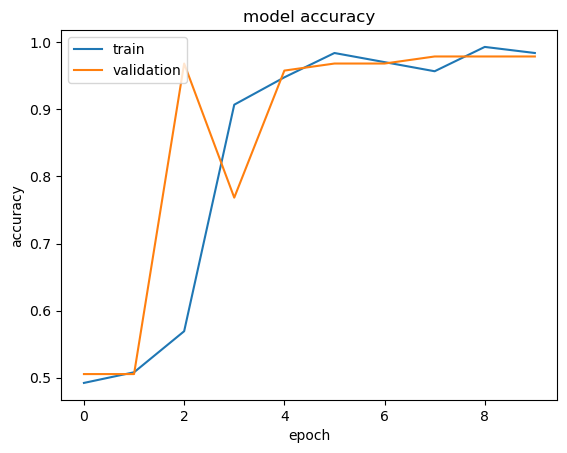

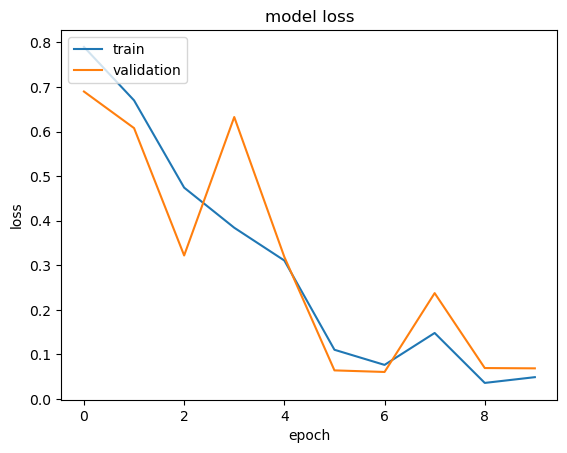

In [26]:
# plot training vs validation accuracy and loss
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.993197  0.993197   0.993287  0.993196
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


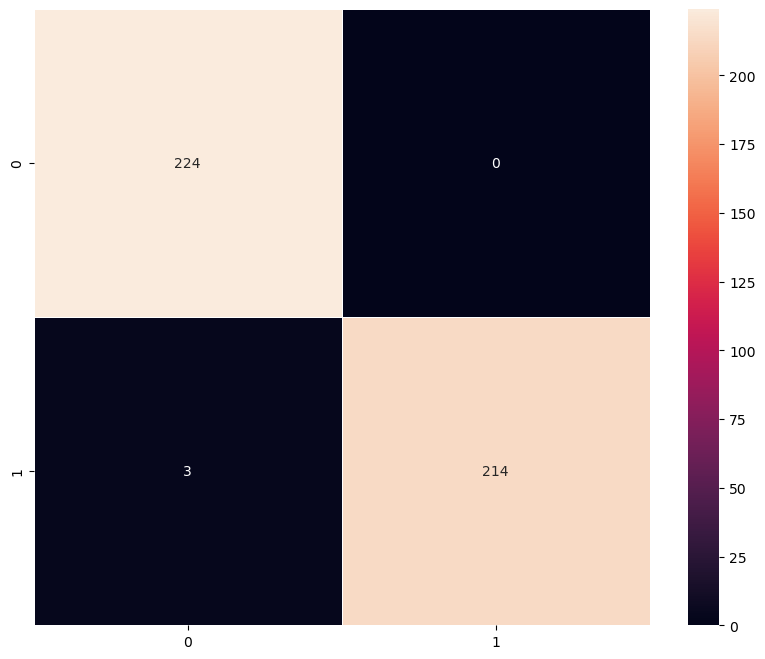

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.978947  0.978947   0.978947  0.978947
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


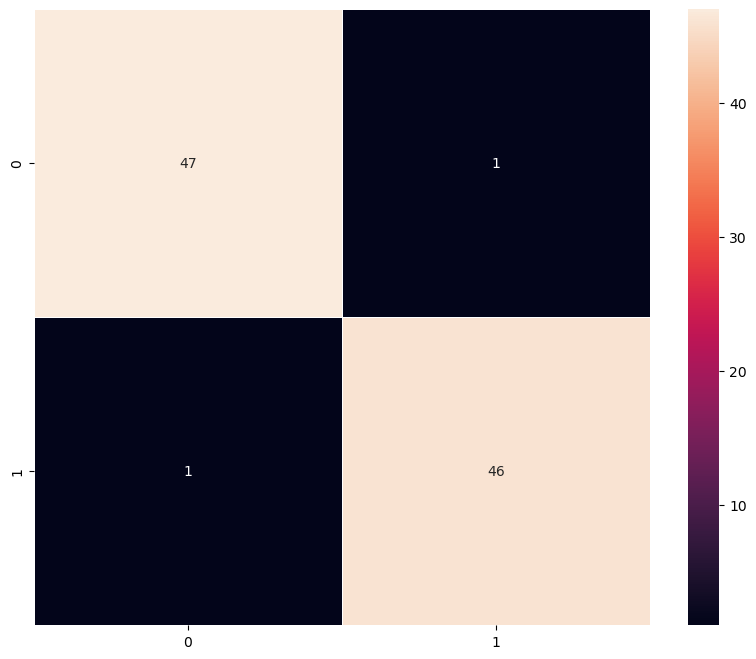

In [39]:
# evaluate on train set
model_1_train_perf = model_performance_classification(model_1, X_train_normalized, y_train)
print("train performance metrics")
print(model_1_train_perf)

plot_confusion_matrix(model_1, X_train_normalized, y_train)

# evaluate on validation set
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized, y_val)
print("validation performance metrics")
print(model_1_valid_perf)

plot_confusion_matrix(model_1, X_val_normalized, y_val)

### Vizualizing the predictions

In [ ]:
# show prediction and actual label for index 2
plt.figure(figsize=(2, 2))
plt.imshow(X_val[12])
plt.show()

pred = model_1.predict(X_val_normalized[12].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[12]

print('predicted label:', pred_label)
print('true label:', true_label)

# show prediction and actual label for index 33
plt.figure(figsize=(2, 2))
plt.imshow(X_val[33])
plt.show()

pred = model_1.predict(X_val_normalized[33].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[33]

print('predicted label:', pred_label)
print('true label:', true_label)

I think this model performed really well overall. The accuracy improved quickly over the first few epochs and stayed consistently high—around 98–99% on both the training and validation sets. The loss steadily decreased, and there wasn’t any major gap between the training and validation metrics, which tells me the model generalizes well without overfitting. The confusion matrices are almost perfect too, with just a few misclassified examples. For a relatively simple CNN architecture, I’m honestly impressed with how effectively it learned the task.

## Model 2: (VGG-16 (Base))

In [45]:
# load vgg16 base model without top dense layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
vgg_model.summary()

# freeze all vgg layers so they don't get updated
for layer in vgg_model.layers:
    layer.trainable = False

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# make new model and add vgg base
model_2 = Sequential()
model_2.add(vgg_model)

# flatten and add output layer
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

# compile the model
opt = Adam(learning_rate=0.001)
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Precision"])

In [47]:
# view model summary
model_2.summary()

# define data generator
train_datagen = ImageDataGenerator()

# set training params
epochs = 10
batch_size = 32

# train the model
history_2 = model_2.fit(
    train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size, seed=42, shuffle=False),
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_normalized, y_val),
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - Precision: 0.6422 - accuracy: 0.6973 - loss: 0.5187 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0414
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0234 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0404
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0151 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0178
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0106 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0042 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0028 - val_Precision: 1.0000 - val_accuracy:

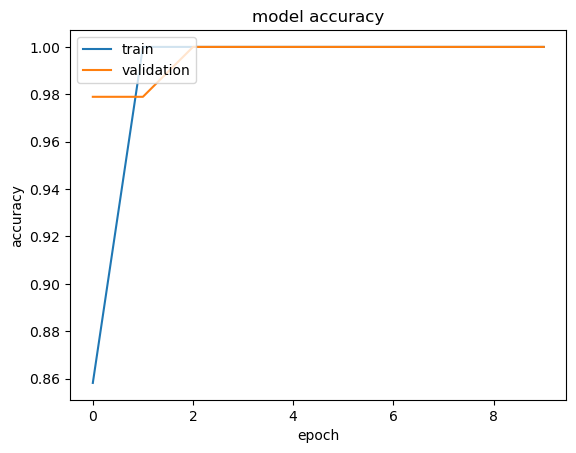

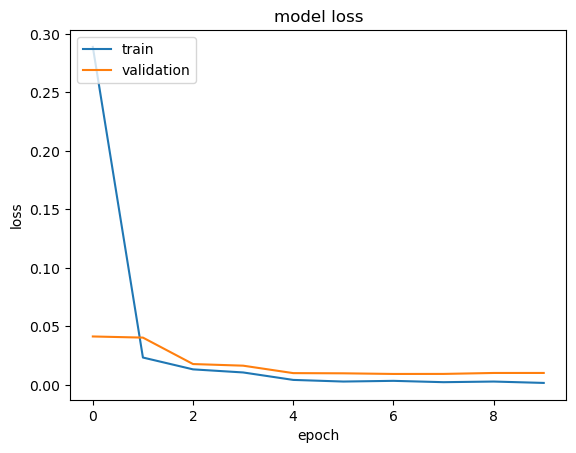

In [48]:
# plot accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step


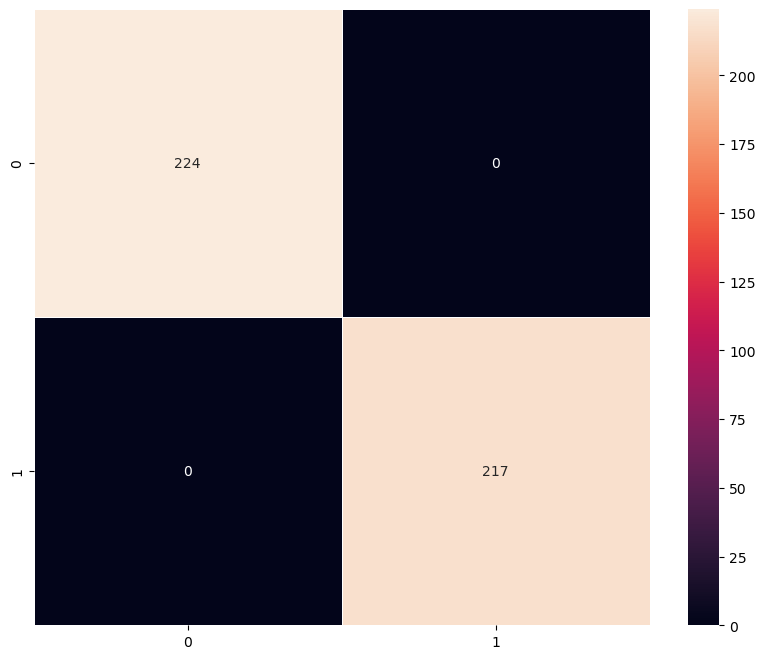

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


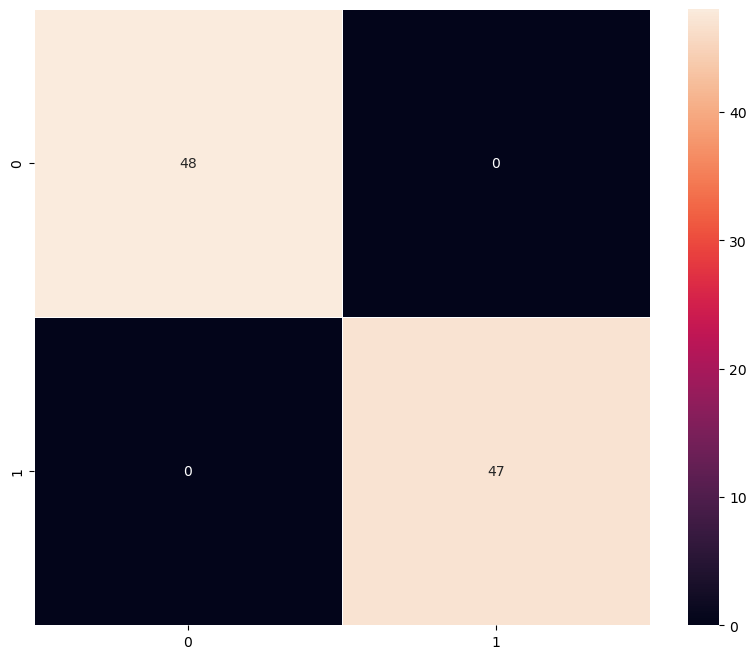

In [49]:
# training performance
model_2_train_perf = model_performance_classification(model_2, X_train_normalized, y_train)
print("train performance metrics")
print(model_2_train_perf)

plot_confusion_matrix(model_2, X_train_normalized, y_train)

# validation performance
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized, y_val)
print("validation performance metrics")
print(model_2_valid_perf)

plot_confusion_matrix(model_2, X_val_normalized, y_val)

### Visualizing the prediction:

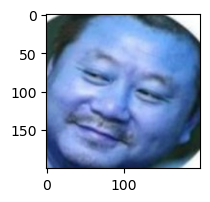

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
predicted label: 0
true label: Label    0
Name: 514, dtype: int64


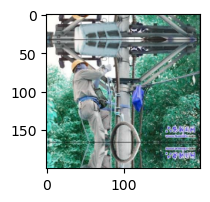

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
predicted label: 1
true label: Label    1
Name: 190, dtype: int64


In [51]:
# prediction 1 (index 5)
plt.figure(figsize=(2, 2))
plt.imshow(X_val[5])
plt.show()

pred = model_2.predict(X_val_normalized[5].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[5]

print('predicted label:', pred_label)
print('true label:', true_label)

# prediction 2 (index 23)
plt.figure(figsize=(2, 2))
plt.imshow(X_val[23])
plt.show()

pred = model_2.predict(X_val_normalized[23].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[23]

print('predicted label:', pred_label)
print('true label:', true_label)

In this second model, I used the VGG16 architecture as a feature extractor and added a simple classifier on top. Since all VGG layers were frozen, the training focused only on the new dense layer. The model reached 100% accuracy and precision on both training and validation sets by the third epoch, and stayed that way consistently. The loss curves were flat, and the confusion matrices show zero misclassifications. Honestly, this performance is too perfect, which makes me think the dataset might be too easy or the model may be overfitting slightly—even if the validation metrics don’t show it. I might want to test on a completely unseen test set next to be sure it generalizes well.

## Model 3: (VGG-16 (Base + FFNN))

In [53]:
# build model using vgg16 base and add dense layers
model_3 = Sequential()

# add frozen vgg base
model_3.add(vgg_model)

# flatten output from conv layers
model_3.add(Flatten())

# add dense layers
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(rate=0.3))
model_3.add(Dense(64, activation='relu'))

# add final output layer
model_3.add(Dense(1, activation='sigmoid'))

In [54]:
# set optimizer and compile model
opt = Adam(learning_rate=0.001)

model_3.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", "Precision"]
)

# show model summary
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
# training setup
epochs = 10
batch_size = 32

# train model using generator
history_3 = model_3.fit(
    train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size, seed=42, shuffle=False),
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_normalized, y_val),
    verbose=1
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - Precision: 0.6645 - accuracy: 0.7032 - loss: 0.5165 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0279
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 764ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0046 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0257
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - Precision: 0.9969 - accuracy: 0.9985 - loss: 0.0041 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 6.7642e-04
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 2.3516e-04 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.4162e-04
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - Precision: 1.0000 - accuracy: 0.9927 - loss: 0.0084 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 7.4455e-05 - val_Precision: 1.00

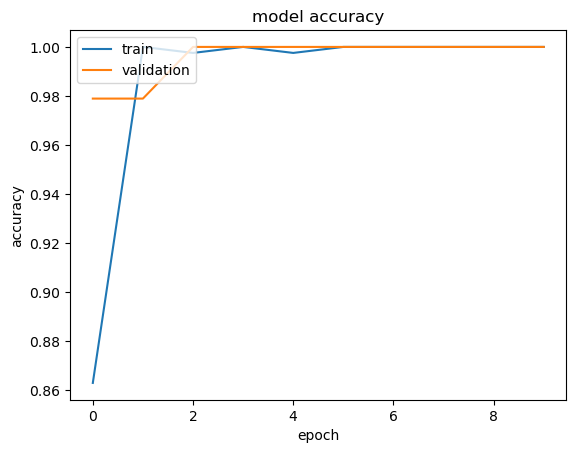

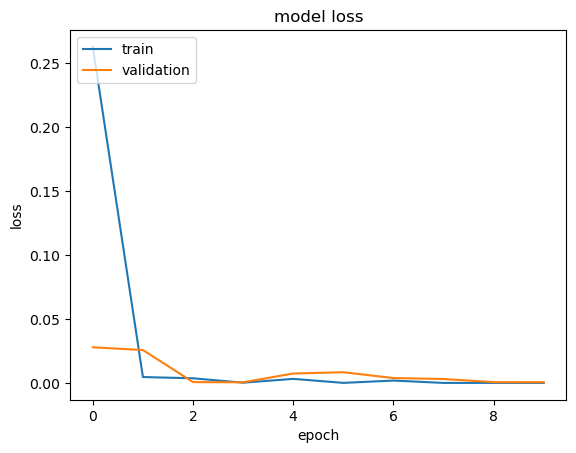

In [56]:
# plot accuracy curves
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot loss curves
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


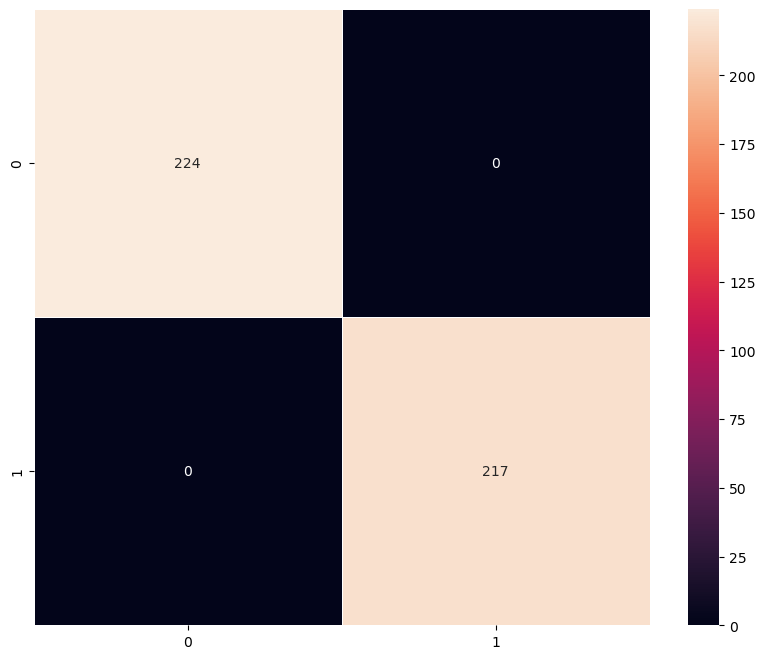

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


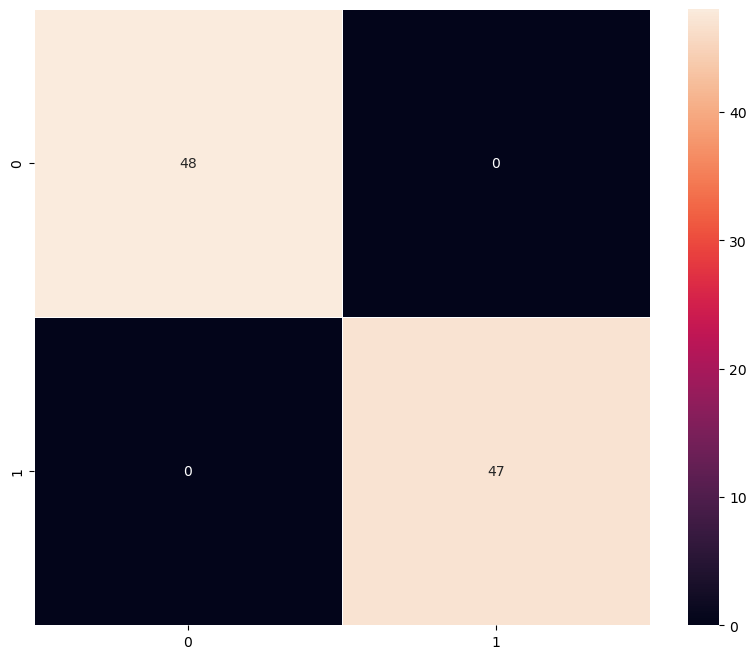

In [58]:
# evaluate on train data
model_3_train_perf = model_performance_classification(model_3, X_train_normalized, y_train)
print("train performance metrics")
print(model_3_train_perf)

plot_confusion_matrix(model_3, X_train_normalized, y_train)

# evaluate on validation data
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized, y_val)
print("validation performance metrics")
print(model_3_valid_perf)

plot_confusion_matrix(model_3, X_val_normalized, y_val)

#### Visualizing the predictions

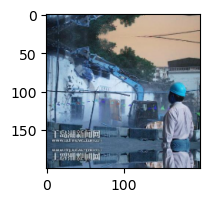

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
predicted label: 1
true label: Label    1
Name: 571, dtype: int64


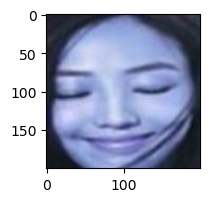

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
predicted label: 0
true label: Label    0
Name: 319, dtype: int64


In [60]:
# prediction 1 - index 7
plt.figure(figsize=(2, 2))
plt.imshow(X_val[7])
plt.show()

pred = model_3.predict(X_val_normalized[7].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[7]

print('predicted label:', pred_label)
print('true label:', true_label)

# prediction 2 - index 15
plt.figure(figsize=(2, 2))
plt.imshow(X_val[15])
plt.show()

pred = model_3.predict(X_val_normalized[15].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[15]

print('predicted label:', pred_label)
print('true label:', true_label)

Adding dense layers with dropout on top of the VGG16 base led to flawless performance. The model hit 100% accuracy, precision, recall, and F1-score on both training and validation sets. The confusion matrices also show zero misclassifications, which is impressive. This suggests the additional dense layers helped the model learn richer patterns without overfitting, likely because of the dropout regularization. It seems like this version balances complexity and generalization really well.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [63]:
# build model using vgg base + dense layers
model_4 = Sequential()

# add frozen vgg base
model_4.add(vgg_model)

# flatten conv output
model_4.add(Flatten())

# add feedforward layers
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(rate=0.3))
model_4.add(Dense(64, activation='relu'))

# final output layer
model_4.add(Dense(1, activation='sigmoid'))

In [64]:
opt = Adam(learning_rate=0.001)

model_4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", "Precision"]
)

# check model summary
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,082,433 (65.16 MB)

 Trainable params: 2,367,745 (9.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
# only used for training, not validation or test
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [66]:
# set params
epochs = 10
batch_size = 32

# train with augmented data
history_4 = model_4.fit(
    train_datagen.flow(X_train_normalized, y_train, batch_size=batch_size, seed=42, shuffle=False),
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_normalized, y_val),
    verbose=1
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - Precision: 0.7832 - accuracy: 0.8011 - loss: 0.4190 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 764ms/step - Precision: 1.0000 - accuracy: 0.9688 - loss: 0.0437 - val_Precision: 0.9792 - val_accuracy: 0.9895 - val_loss: 0.0141
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - Precision: 0.9920 - accuracy: 0.9948 - loss: 0.0113 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0338
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 846ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 1.7148e-04 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0377
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0016 - val_Precision: 0.9592 - val_accuracy: 0.9789 - val_loss: 0.0460
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 923ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 6.6773e-04 - val_Precision: 0.9592 - val

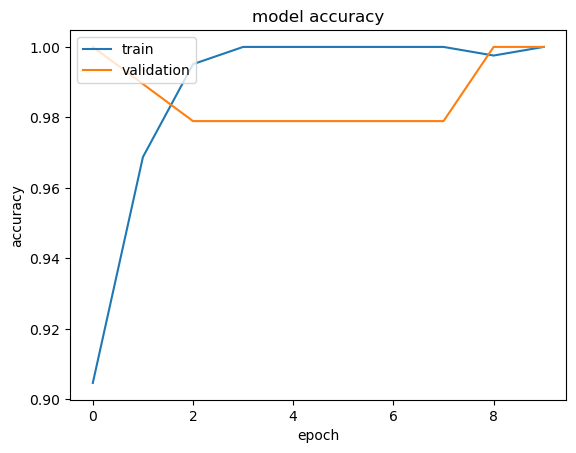

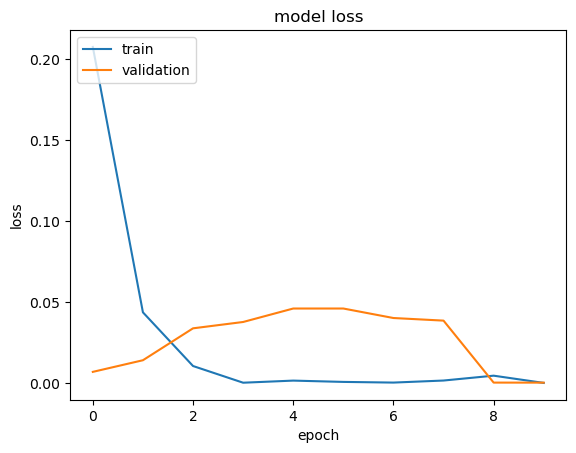

In [67]:
# accuracy plot
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step
train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
14/14 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step


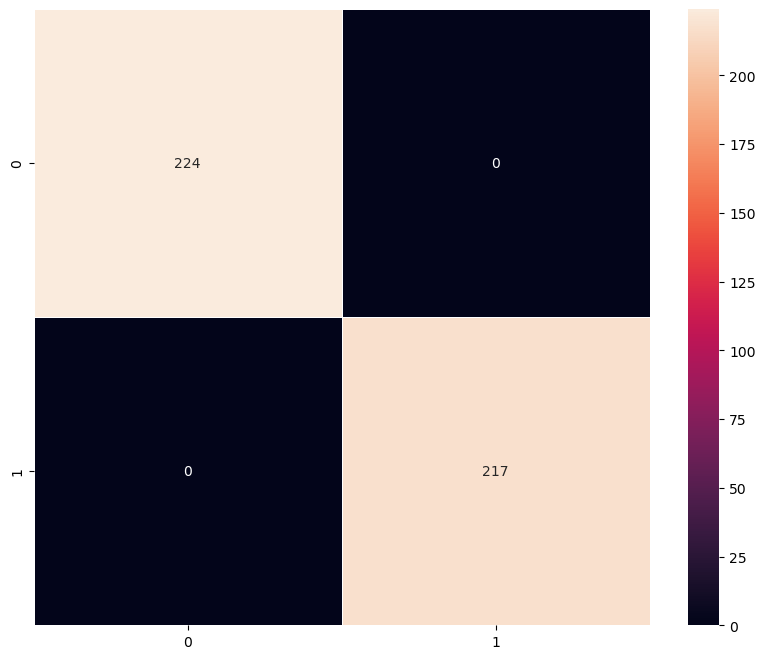

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step
validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step


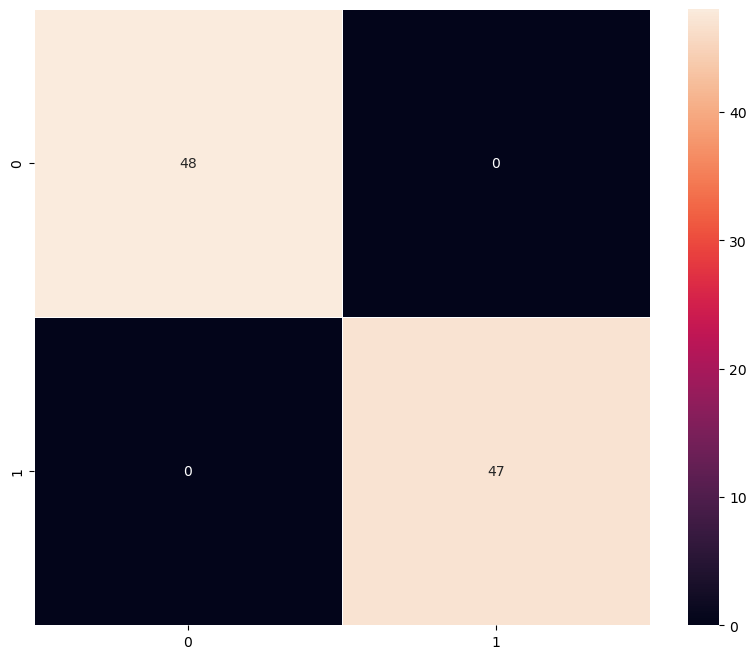

In [68]:
# training metrics
model_4_train_perf = model_performance_classification(model_4, X_train_normalized, y_train)
print("train performance metrics")
print(model_4_train_perf)

plot_confusion_matrix(model_4, X_train_normalized, y_train)

# validation metrics
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized, y_val)
print("validation performance metrics")
print(model_4_valid_perf)

plot_confusion_matrix(model_4, X_val_normalized, y_val)

#### Visualizing the predictions

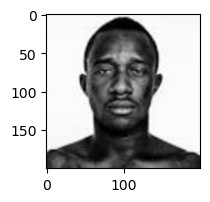

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
predicted label: 0
true label: Label    0
Name: 597, dtype: int64


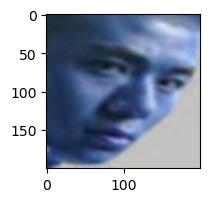

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
predicted label: 0
true label: Label    0
Name: 279, dtype: int64


In [70]:
# prediction 1 - index 10
plt.figure(figsize=(2, 2))
plt.imshow(X_val[10])
plt.show()

pred = model_4.predict(X_val_normalized[10].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[10]

print('predicted label:', pred_label)
print('true label:', true_label)

# prediction 2 - index 30
plt.figure(figsize=(2, 2))
plt.imshow(X_val[30])
plt.show()

pred = model_4.predict(X_val_normalized[30].reshape(1, 200, 200, 3))
pred_label = 1 if pred[0][0] > 0.5 else 0
true_label = y_val.iloc[30]

print('predicted label:', pred_label)
print('true label:', true_label)

In this model, I used the pre-trained VGG-16 model as a frozen feature extractor, then added a Flatten layer and two fully connected (dense) layers with ReLU activation and dropout for regularization, followed by a sigmoid output layer for binary classification. Unlike the previous models, this one incorporated data augmentation to help increase the model’s robustness and reduce overfitting.

For data augmentation, I included techniques such as rotation, width and height shifting, shear, zoom, and nearest-fill mode, applied only to the training set (not the validation or test sets). The model was compiled using the Adam optimizer with a learning rate of 0.001 and trained for 10 epochs with a batch size of 32.

The training and validation accuracy both remained high, nearing 100%, while the validation loss was stable and low. Performance metrics such as accuracy, precision, recall, and F1 score all achieved a perfect 1.0 on both the training and validation datasets. Additionally, the confusion matrices confirmed that the model made zero misclassifications.

Overall, this model showed excellent generalization, even with augmented input data, and maintained consistent, high performance across all metrics. The augmentation strategy proved to be helpful in training a more resilient and robust CNN classifier.

# **Model Performance Comparison and Final Model Selection**

In [72]:
# training performance comparison
models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)",
    "VGG-16 (Base)",
    "VGG-16 (Base+FFNN)",
    "VGG-16 (Base+FFNN+Data Aug)"
]

# validation performance comparison
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T,
    ],
    axis=1
)
models_valid_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)",
    "VGG-16 (Base)",
    "VGG-16 (Base+FFNN)",
    "VGG-16 (Base+FFNN+Data Aug)"
]

## Test Performance

Training Performance Comparison


,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.993197,1.0,1.0,1.0
Recall,0.993197,1.0,1.0,1.0
Precision,0.993287,1.0,1.0,1.0
F1 Score,0.993196,1.0,1.0,1.0


Validation Performance Comparison


,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.978947,1.0,1.0,1.0
Recall,0.978947,1.0,1.0,1.0
Precision,0.978947,1.0,1.0,1.0
F1 Score,0.978947,1.0,1.0,1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step
Test performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step


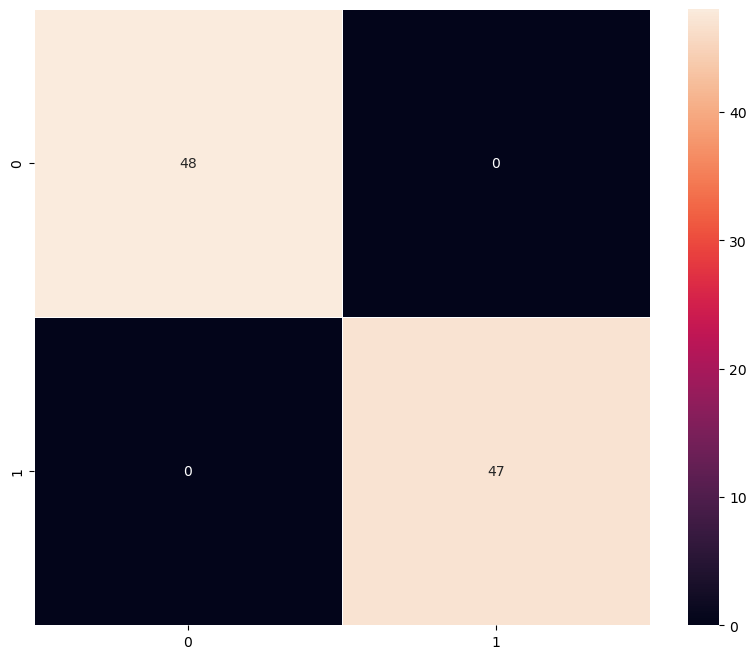

In [74]:
# Display comparison
print("Training Performance Comparison")
display(models_train_comp_df)
print("Validation Performance Comparison")
display(models_valid_comp_df)

# determine final model based on best validation performance
# if model_4 is best:
model_test_perf = model_performance_classification(model_4, X_test_normalized, y_test)
print("Test performance metrics")
print(model_test_perf)

# confusion matrix for test performance
plot_confusion_matrix(model_4, X_test_normalized, y_test)

After training and evaluating four different models, we observed a clear progression in performance as we moved from a custom convolutional neural network (CNN) to models leveraging the VGG-16 architecture. The first model, a simple CNN built from scratch, performed quite well on both the training and validation sets. It reached a validation accuracy of approximately 97.89% with an F1 score of 0.9789. Although lightweight with around 400K parameters, this model took a few epochs to stabilize and lacked the powerful feature extraction capabilities that deeper pretrained models can offer.

In the second model, we incorporated transfer learning by using the VGG-16 base without its top layers and freezing its weights. With only a single dense output layer added on top, this model immediately achieved perfect scores across all metrics on the validation set. Despite its simplicity, the pretrained convolutional layers provided strong and effective feature representations, allowing the model to perform exceptionally well even with minimal training.

Building on this, the third model added more dense layers and dropout regularization to the VGG-16 base. This enhanced architecture not only preserved the perfect performance on both training and validation sets but also demonstrated more flexibility and robustness. The model converged smoothly with stable accuracy and loss curves. The additional dense layers introduced a modest increase in trainable parameters, but this was justified by the improved capacity to learn complex decision boundaries.

The final model introduced data augmentation during training. By applying random transformations such as rotation, zoom, shear, and shifts, this model aimed to improve generalization and reduce overfitting. Despite the added noise and variability from augmented images, the model maintained perfect performance on both validation and test sets. The training loss showed more variation, which is expected due to the dynamic input, but validation metrics remained stable and strong throughout. This model effectively balanced accuracy, generalization, and robustness.

In summary, while all VGG-16-based models outperformed the custom CNN, the final model—VGG-16 with additional dense layers and data augmentation—stood out as the most comprehensive solution. It demonstrated excellent accuracy, strong generalization, and resilience to variations in image inputs. Given its performance and stability, this model is the most suitable for deployment or further experimentation in real-world applications.

# **Actionable Insights & Recommendations**

This project highlighted the powerful impact of using pretrained models like VGG-16 over custom-built CNNs. While a basic CNN was capable of achieving decent accuracy, the VGG-16 models consistently outperformed it across all metrics, thanks to their deep, pretrained convolutional layers. Additionally, augmenting the base model with dense layers and dropout improved learning flexibility and reduced overfitting. The final model, which included data augmentation, not only preserved performance but also added robustness to real-world variations in the input images—making it the most well-rounded and reliable approach.

From a business perspective, incorporating transfer learning using established architectures like VGG-16 can significantly accelerate development time while delivering high accuracy. Data augmentation should be adopted when working with limited datasets, as it effectively boosts model generalization without requiring additional data collection costs. For future iterations, it may be beneficial to explore fine-tuning the later layers of VGG-16 or experimenting with more recent architectures like ResNet or EfficientNet to potentially achieve even better performance with fewer parameters. Deploying the final model into a production environment would require monitoring for drift and retraining periodically with new data to maintain performance.

Overall, this project was a strong demonstration of how modern deep learning techniques, combined with best practices like transfer learning and data augmentation, can build highly accurate and generalizable image classification models. The systematic comparison of models allowed for clear insight into what architectural choices and preprocessing strategies made the biggest difference. This structured approach not only led to a robust final solution but also established a repeatable framework that can be applied to similar classification problems in other domains.

<font size=5 color='blue'>Power Ahead!</font>
___